In [ ]:
# make a neat function of this, if motion energy seems useful

In [272]:
import os
import numpy as np
import json
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
dlc_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")
motion_energy_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy/Bergamo-2P-Photostim/")
mouse = "BCI_34"
FOV = "FOV_04"
session = "071922"
overwrite = False
extract_motion_energy_from_session(bpod_path,
                                      dlc_base_dir,
                                      raw_video_path,
                                      motion_energy_base_dir,
                                      mouse,
                                      FOV,
                                      session,
                                      overwrite)


def extract_motion_energy_from_session(bpod_path,
                                      dlc_base_dir,
                                      raw_video_path,
                                      motion_energy_base_dir,
                                      mouse,
                                      FOV,
                                      session,
                                      overwrite):
    
    camera = "side"
    bpod_filepath = os.path.join(bpod_path, mouse, session+"-bpod_zaber.npy")
    bpod_data = np.load(bpod_filepath, allow_pickle=True).tolist()
    behavior_movie_names_ = bpod_data['behavior_movie_name_list']
    behavior_movie_names = []
    for bmn in behavior_movie_names_:
        if not type(bmn)==np.str_:
            behavior_movie_names.append(bmn)
    behavior_movie_names = np.unique(np.concatenate(behavior_movie_names))

    # load all dlc files and extract median part pixels

    dlc_trial_list = []
    file_exist_list = []
    bmn = behavior_movie_names[0]
    residual_path = bmn[bmn.find(camera):].strip("'")
    save_dir = os.path.join(*np.concatenate([[motion_energy_base_dir],residual_path.split('/')[:-1]]))
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    for bmn in behavior_movie_names: # read in all dlc files to calculate location of ROIs
        if camera not in bmn:
            continue
        dlc_file_name = bmn[bmn.find(camera)+len(camera)+1:].split("/") #[mouse, session_id, trial_id]
        dlc_folder = os.path.join(dlc_base_dir, camera, dlc_file_name[0], dlc_file_name[1])
        trial_id = dlc_file_name[2][:-5]

        trial_csv = [k for k in next(os.walk(dlc_folder))[2] if k.startswith(trial_id) and k.endswith("csv")][0]
        dlc_trial = pd.read_csv(os.path.join(dlc_folder, trial_csv), header=[1,2], index_col=0)
        dlc_trial_list.append(dlc_trial)
        
        residual_path = bmn[bmn.find(camera):].strip("'")
        if os.path.exists(os.path.join(save_dir,residual_path.split('/')[-1][:-3]+'npy')):
            file_exist_list.append(True)
        else:
            file_exist_list.append(False)
    if (sum(file_exist_list) == len(file_exist_list)) and not overwrite:
        print('all files already exist, skipping motion energy export')
        return None
    else:
        print('{}% of files exported, exporting motion energy of {}'.format(100*np.round(sum(file_exist_list) == len(file_exist_list),3),
                                                                           save_dir))
        
        

    DLC_concat = pd.concat(dlc_trial_list,axis=0, ignore_index = True)        
    medians = DLC_concat.median()

    # edge of rectangle
    face_edge_point_markers ={'whisker': ['EyeRight','NoseTip','Jaw'],
                             'body':['PawR','PawL','Jaw']}
    taper_proportion = 0.2
    edge_values_dict = {}
    for roi in face_edge_point_markers.keys():
        edge_values_dict[roi] = {}
        for dim in ['x','y']:
            edge_values_dict[roi][dim] = []
            for part in face_edge_point_markers[roi]:
                edge_values_dict[roi][dim].append(medians[part][dim])

            edge_values_dict[roi][dim] = np.asarray([np.min(edge_values_dict[roi][dim]),np.max(edge_values_dict[roi][dim])])
            diff = np.diff(edge_values_dict[roi][dim])[0]
            edge_values_dict[roi][dim] = np.asarray([edge_values_dict[roi][dim][0]+diff*taper_proportion,edge_values_dict[roi][dim][-1]-diff*taper_proportion],int)
    # extract frames from movies

    image_done = False
    for bmn in behavior_movie_names:
        if camera not in bmn:
            continue
        cutouts = {}

        for roi in face_edge_point_markers.keys():
            cutouts[roi] = []
        residual_path = bmn[bmn.find(camera):].strip("'")
        video_path = os.path.join(raw_video_path,residual_path)
        cap = cv2.VideoCapture(video_path)
        while(cap.isOpened()):

            ret, frame = cap.read()
            if ret == True:
                for i, roi in enumerate(face_edge_point_markers.keys()):
                    cutout = frame[edge_values_dict[roi]['y'][0]:edge_values_dict[roi]['y'][1],
                                   edge_values_dict[roi]['x'][0]:edge_values_dict[roi]['x'][1],
                                   0]
                    cutouts[roi].append(cutout)
            else: 
                break

            if not image_done:

                fig = plt.figure(figsize = [15,15])
                ax1 = fig.add_subplot(2,2,1)

                ax1.imshow(frame[:,:,0],cmap = 'gray')
                for i, roi in enumerate(face_edge_point_markers.keys()):
                    ax1.add_patch(Rectangle((edge_values_dict[roi]['x'][0],edge_values_dict[roi]['y'][0]),np.diff(edge_values_dict[roi]['x'])[0],np.diff(edge_values_dict[roi]['y'])[0],
                                    edgecolor='red',
                                    facecolor='none',
                                    lw=4))
                    cutout = frame[edge_values_dict[roi]['y'][0]:edge_values_dict[roi]['y'][1],
                                   edge_values_dict[roi]['x'][0]:edge_values_dict[roi]['x'][1],
                                   0]
                    ax2 = fig.add_subplot(2,2,3+i)
                    ax2.imshow(cutout,cmap = 'gray')
                    ax2.set_title(roi)
                image_done = True
                fig.savefig(os.path.join(save_dir,residual_path.split('/')[-1][:-3]+'jpg'))
                asdasdsa
        # When everything done, release the video capture object
        cap.release()
        out_dict = {'motion_energy_traces':{},
                   'face_edge_point_markers':face_edge_point_markers,
                   'edge_values':edge_values_dict,
                   }
        for i, roi in enumerate(face_edge_point_markers.keys()):
            out_dict['motion_energy_traces'][roi] = np.mean(np.abs(np.diff(np.asarray(cutouts[roi],float),axis=0)),(1,2))
        
        np.save(os.path.join(save_dir,residual_path.split('/')[-1][:-3]+'npy'),out_dict)
    


all files already exist, skipping


NameError: name 'asdasdsa' is not defined

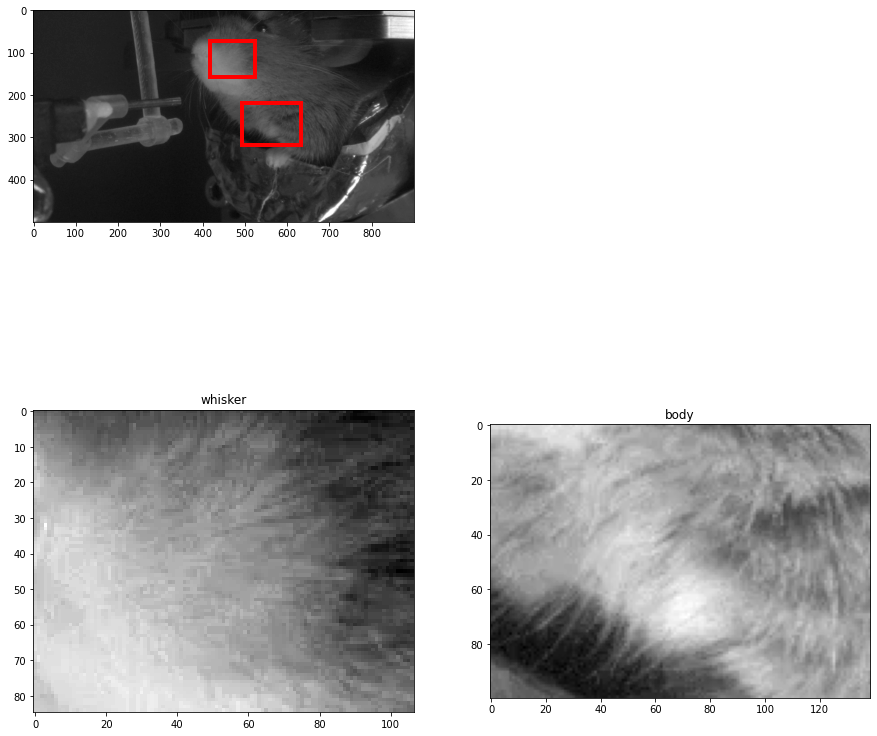

In [273]:
extract_motion_energy_from_session(bpod_path,
                                      dlc_base_dir,
                                      raw_video_path,
                                      motion_energy_base_dir,
                                      mouse,
                                      FOV,
                                      session,
                                      overwrite)